# MS-CELEB Face Recognition

## Importing the libraries


In [90]:
import os
import shutil
import pathlib
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory


# to make this notebook's output stable across runs
np.random.seed(42)

# Constants
SIZE_OF_IMAGES = (192, 192)
SIZE_OF_BATCH = 64
DATA_DIR = pathlib.Path('./data/MS_CELEB_20KnownCat/')
MODELS_DIR = pathlib.Path('./models')

print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Functions

In [91]:

def plot_history(history):
    """"Plot the accuracy, loss, precision, recall and AUC \
        curves for training and validation."""

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    auc = history.history["auc"]
    val_auc = history.history["val_auc"]

    precision = history.history["precision"]
    val_precision = history.history["val_precision"]

    recall = history.history["recall"]
    val_recall = history.history["val_recall"]

    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 12))

    plt.subplot(321)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(322)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.grid()

    plt.subplot(323)
    plt.plot(epochs, precision, "bo", label="Training precision")
    plt.plot(epochs, val_precision, "b", label="Validation precision")
    plt.title("Training and validation precision")
    plt.legend()
    plt.grid()

    plt.subplot(324)
    plt.plot(epochs, recall, "bo", label="Training recall")
    plt.plot(epochs, val_recall, "b", label="Validation recall")
    plt.title("Training and validation recall")
    plt.legend()
    plt.grid()

    plt.subplot(3, 2, (5, 6))
    plt.plot(epochs, auc, "bo", label="Training AUC")
    plt.plot(epochs, val_auc, "b", label="Validation AUC")
    plt.title("Training and validation AUC")
    plt.legend()
    plt.grid()

    plt.show()


def show_eval_results(test_model, test_dataset, labels=None):
    """Evaluate the model on the test dataset and print the results."""

    eval_results = test_model.evaluate(test_dataset, labels)

    print(f"Test loss: {eval_results[0]:.3f}")
    print(f"Test accuracy: {eval_results[1]:.3f}")
    print(f"Test AUC: {eval_results[2]:.3f}")
    print(f"Test Precision: {eval_results[3]:.3f}")
    print(f"Test Recall: {eval_results[4]:.3f}")


## Importing the data

In [92]:
train_dataset = image_dataset_from_directory(DATA_DIR,
                                             image_size=SIZE_OF_IMAGES,
                                             batch_size=SIZE_OF_BATCH,
                                             label_mode='categorical',
                                             color_mode='rgb',
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(DATA_DIR,
                                                  image_size=SIZE_OF_IMAGES,
                                                  batch_size=SIZE_OF_BATCH,
                                                  label_mode='categorical',
                                                  color_mode='rgb',
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  seed=42)

Found 1939 files belonging to 20 classes.
Using 1552 files for training.
Found 1939 files belonging to 20 classes.
Using 387 files for validation.


In [93]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (64, 192, 192, 3)
labels batch shape: (64, 20)


## Importing The Mobile Net

In [94]:
conv_base = tf.keras.applications.mobilenet.MobileNet(
    weights='imagenet', input_shape=(192, 192, 3), include_top=False)
conv_base.trainable = False

In [95]:
conv_base.summary()


Model: "mobilenet_1.00_192"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 192, 192, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 96, 96, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 96, 96, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 96, 96, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 96, 96, 32)       128       
 ation)                                         

In [96]:
# import keras_cv

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),

    ]
)


In [97]:
inputs = keras.Input(shape=SIZE_OF_IMAGES + (3,))
x = data_augmentation(inputs)
x = keras.applications.mobilenet.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(20, activation='softmax')(x)

model = keras.Model(inputs=inputs,
                    outputs=outputs,
                    name='MobileNet_FeatExtr_DataAugm')

model.summary()

Model: "MobileNet_FeatExtr_DataAugm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 192, 192, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 192, 192, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 192, 192, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_192 (Functio  (None, 6, 6, 1024)       3228864   
 nal)                                                            
                                       

In [98]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, 'MobileNet_FeatExtr_DataAugmnt.keras'),
        save_best_only=True,
        monitor="val_loss"),
]

history = model.fit(train_dataset,
                    epochs=200,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/100
25/25 [==============================] - 6s 173ms/step - loss: 102.2420 - accuracy: 0.3479 - auc: 0.6654 - precision: 0.3518 - recall: 0.3473 - val_loss: 42.9982 - val_accuracy: 0.4393 - val_auc: 0.7124 - val_precision: 0.4393 - val_recall: 0.4393
Epoch 2/100
25/25 [==============================] - 3s 131ms/step - loss: 22.7540 - accuracy: 0.6540 - auc: 0.8285 - precision: 0.6540 - recall: 0.6540 - val_loss: 33.2668 - val_accuracy: 0.5297 - val_auc: 0.7599 - val_precision: 0.5297 - val_recall: 0.5297
Epoch 3/100
25/25 [==============================] - 3s 105ms/step - loss: 16.4272 - accuracy: 0.7416 - auc: 0.8732 - precision: 0.7426 - recall: 0.7416 - val_loss: 42.4378 - val_accuracy: 0.5607 - val_auc: 0.7763 - val_precision: 0.5607 - val_recall: 0.5607
Epoch 4/100
25/25 [==============================] - 3s 125ms/step - loss: 12.7156 - accuracy: 0.7925 - auc: 0.8978 - precision: 0.7925 - recall: 0.7925 - val_loss: 7.3344 - val_accuracy: 0.8605 - val_auc: 0.9294 - val_pre

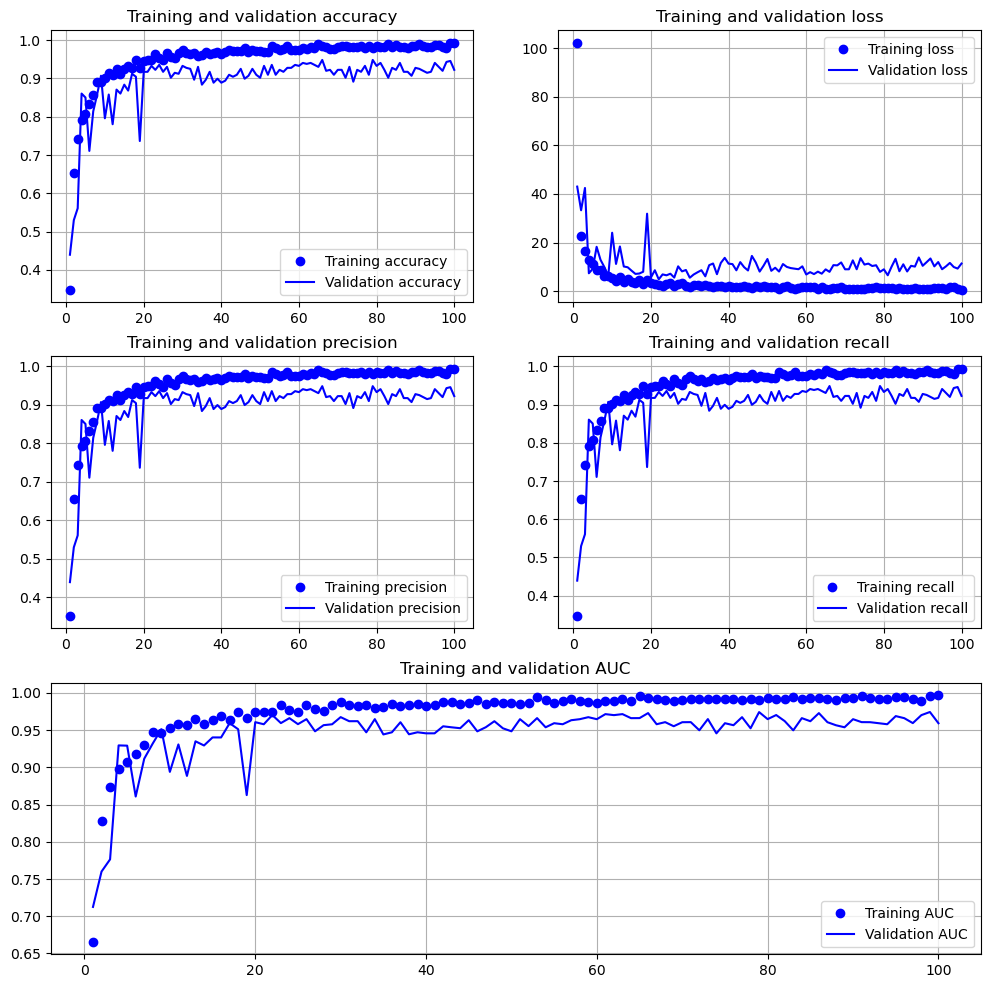

In [99]:
plot_history(history)


In [100]:
show_eval_results(model, validation_dataset)

7/7 [==============================] - 1s 52ms/step - loss: 11.3419 - accuracy: 0.9225 - auc: 0.9592 - precision: 0.9225 - recall: 0.9225
Test loss: 11.342
Test accuracy: 0.922
Test AUC: 0.959
Test Precision: 0.922
Test Recall: 0.922


## Fine-tunning the pre-trained model

In [101]:
conv_base.trainable = True
for layer in conv_base.layers[:-3]:
    layer.trainable = False


In [102]:
conv_base.summary()

Model: "mobilenet_1.00_192"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 192, 192, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 96, 96, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 96, 96, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 96, 96, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 96, 96, 32)       128       
 ation)                                         

### Excluding batch normalization layers

In [103]:
for layer in conv_base.layers:
    if isinstance(layer, (layers.BatchNormalization,)):
        layer.trainable = False


In [104]:
conv_base.summary()

Model: "mobilenet_1.00_192"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 192, 192, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 96, 96, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 96, 96, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 96, 96, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 96, 96, 32)       128       
 ation)                                         

In [106]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, 'MobileNet_FineTunned.keras'),
        save_best_only=True,
        monitor="val_loss"),
]

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset,
                    callbacks=callbacks)


Epoch 1/100
25/25 [==============================] - 5s 140ms/step - loss: 73.2855 - accuracy: 0.8080 - auc: 0.9009 - precision: 0.8080 - recall: 0.8080 - val_loss: 56.6020 - val_accuracy: 0.8062 - val_auc: 0.8981 - val_precision: 0.8062 - val_recall: 0.8062
Epoch 2/100
25/25 [==============================] - 3s 107ms/step - loss: 26.0019 - accuracy: 0.8853 - auc: 0.9403 - precision: 0.8853 - recall: 0.8853 - val_loss: 236.7758 - val_accuracy: 0.5814 - val_auc: 0.7848 - val_precision: 0.5814 - val_recall: 0.5814
Epoch 3/100
25/25 [==============================] - 3s 108ms/step - loss: 31.8296 - accuracy: 0.8827 - auc: 0.9396 - precision: 0.8827 - recall: 0.8827 - val_loss: 61.0840 - val_accuracy: 0.8501 - val_auc: 0.9211 - val_precision: 0.8501 - val_recall: 0.8501
Epoch 4/100
25/25 [==============================] - 3s 116ms/step - loss: 33.3738 - accuracy: 0.8821 - auc: 0.9383 - precision: 0.8821 - recall: 0.8821 - val_loss: 29.6237 - val_accuracy: 0.8837 - val_auc: 0.9401 - val_pr

This MobileNet version 1 cannot be fine-tunned perfectly because it has lot of weights in the last trainable layer which we should fine-tune.